In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lungs-disease-dataset-4-types:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1864500%2F3044546%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240229%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240229T214701Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db7e20275102ad0a180f27953091a5f28f9463a7333b1b160a0dd465901e31f37f41585f4b82147f6fabe8553065c796f50e8676bd150fd7774d2ab57260e0a25fd7960657d42b77ec462463710e103a40a0f56449e8854b2b0796c20af6799abe06e94e89910d652c20479b9b4d02b18644aa46faab6eadcab33c2369ef9f07c93f24f741df781a5cd794958aa9abf34b8bbd7f654b8e54b80d68424ca7f612540188b5c2d0bcc968a5ff3a493134551beb1706091babb98f0d254c934973bc23b248c6152adccaadfc71713714a8bd11ef245bc5001d6be70fd05f04d7e198df1afc9f1784847407b805a7e25bba2b95503c7f3a9b3ff69a1d73dd4a858ce59'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2169396481 bytes downloaded
Downloaded and uncompressed: lungs-disease-dataset-4-types
Data source import complete.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from warnings import filterwarnings
filterwarnings(action="ignore")

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model, load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [5]:
data_path = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"

data = {"images":[], "labels":[], "split_type":[]}
for i in os.listdir(data_path): # Data Split
    split_dir = os.path.join(data_path, i)
    for j in os.listdir(split_dir): # Disease
        d_l = os.path.join(split_dir, j)
        for k in os.listdir(d_l):
            data["images"].append(os.path.join(d_l, k))
            data["labels"].append(j)
            data["split_type"].append(i)

df = pd.DataFrame(data)

print(df.shape)

df.head()

(10095, 3)


,images,labels,split_type
0,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
1,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
2,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
3,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test
4,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia,test


In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df["images"], df["labels"], test_size=0.2, stratify=df["labels"], random_state=42)

xtest, xval, y_test, yval = train_test_split(Xtest, ytest, test_size=0.1, stratify=ytest, random_state=42)

print(Xtrain.shape, xtest.shape, xval.shape)

(8076,) (1817,) (202,)


In [7]:
train = pd.concat([Xtrain, ytrain], axis=1)
test = pd.concat([xtest, y_test], axis=1)
val = pd.concat([xval, yval], axis=1)

In [8]:
base_model = VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3)))

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
base_model_output = base_model.output

x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model_output)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
model_output = Dense(5, activation='softmax')(x)

lungnet = Model(inputs=base_model.input, outputs=model_output)

lungnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
lungnet.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
train_generator = ImageDataGenerator(
                                # rotation_range=90,  # Rotate images randomly by up to 90 degrees
                                # width_shift_range=0.1,  # Shift images horizontally by up to 10% of the width
                                # height_shift_range=0.1,  # Shift images vertically by up to 10% of the height
                                # shear_range=0.2,  # Apply shear transformation
                                # zoom_range=0.2,  # Zoom in or out by up to 20%
                                # horizontal_flip=True,  # Flip images horizontally
                                # vertical_flip=True,  # Flip images vertically
                                # fill_mode='nearest' , # Fill in missing pixels using the nearest value
                                preprocessing_function = preprocess_input
                            )

test_gen = ImageDataGenerator( preprocessing_function = preprocess_input)

In [12]:
train

,images,labels
473,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Normal
1304,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Tuberculosis
9040,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Corona Virus Disease
1836,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Bacterial Pneumonia
5522,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Corona Virus Disease
...,...,...
2324,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia
2395,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Viral Pneumonia
5706,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Tuberculosis
4873,/kaggle/input/lungs-disease-dataset-4-types/Lu...,Corona Virus Disease


In [13]:
X = train_generator.flow_from_dataframe(dataframe=train, x_col="images", y_col="labels", batch_size=32, target_size=(224, 224))
x = test_gen.flow_from_dataframe(dataframe=train, x_col="images", y_col="labels", batch_size=32, target_size=(224, 224))

Found 8076 validated image filenames belonging to 5 classes.
Found 8076 validated image filenames belonging to 5 classes.


In [14]:
lungnet_history = lungnet.fit(X,
                    validation_data=x,
                    epochs=20,
                    callbacks=[callbacks.EarlyStopping(patience=4),
                               callbacks.ReduceLROnPlateau(patience=2),
                               callbacks.ModelCheckpoint("/content/drive/MyDrive/models/lungnet.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')])

Epoch 1/20
253/253 [==============================] - ETA: 0s - loss: 1.2085 - accuracy: 0.4349
Epoch 1: val_loss improved from inf to 0.69212, saving model to /content/drive/MyDrive/models/lungnet.h5
253/253 [==============================] - 224s 784ms/step - loss: 1.2085 - accuracy: 0.4349 - val_loss: 0.6921 - val_accuracy: 0.6913 - lr: 1.0000e-04
Epoch 2/20
253/253 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.7329
Epoch 2: val_loss improved from 0.69212 to 0.49196, saving model to /content/drive/MyDrive/models/lungnet.h5
253/253 [==============================] - 196s 773ms/step - loss: 0.5878 - accuracy: 0.7329 - val_loss: 0.4920 - val_accuracy: 0.7931 - lr: 1.0000e-04
Epoch 3/20
253/253 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8084
Epoch 3: val_loss improved from 0.49196 to 0.40327, saving model to /content/drive/MyDrive/models/lungnet.h5
253/253 [==============================] - 192s 758ms/step - loss: 0.4356 - accuracy:

In [15]:
loaded_model = load_model("/content/drive/MyDrive/models/lungnet.h5")

In [16]:
validation = test_gen.flow_from_dataframe(dataframe=val, x_col="images", y_col="labels", target_size=(224, 224))

Found 202 validated image filenames belonging to 5 classes.


In [17]:
loaded_model.evaluate(validation)

7/7 [==============================] - 6s 847ms/step - loss: 0.5451 - accuracy: 0.9109


[0.5451376438140869, 0.9108911156654358]

<Axes: >

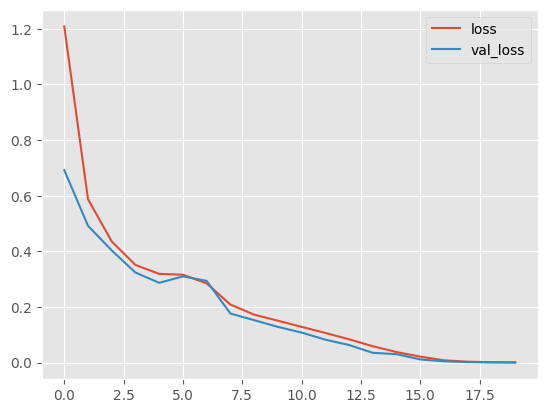

In [18]:
pd.DataFrame(lungnet_history.history)[["loss", "val_loss"]].plot()

<Axes: >

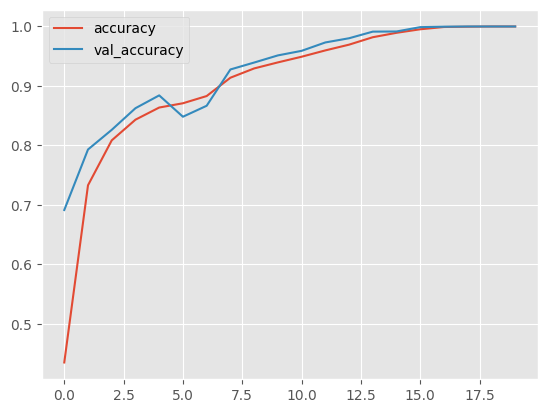

In [19]:
pd.DataFrame(lungnet_history.history)[["accuracy", "val_accuracy"]].plot()